Imports

In [1]:
import numpy as np
import pandas as pd

import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading

Neural Network API

In [2]:
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural network functionality
import torch.nn.functional as F           # functional programming tools: layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
#from torch.jit import script, trace       # hybrid frontend decorator and tracing jit

GPU Usage

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device") # here are some commented lines for change test 

Using cuda device


Path to patient directory: C:/Users/fahim/Documents/Research_project/F2NetViT/Dataset/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03028-100
Path to label: C:/Users/fahim/Documents/Research_project/F2NetViT/Dataset/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03028-100\BraTS-GLI-03028-100-seg.nii.gz
(data_provider_brats.py) Before transform - Image shape: (4, 80, 80, 80), Label shape: (4, 80, 80, 80)
(data_provider_brats.py) After transform - Image shape: (4, 80, 80, 80), Label shape: (4, 80, 80, 80)
torch.Size([1, 4, 80, 80, 80]) torch.Size([1, 4, 80, 80, 80])


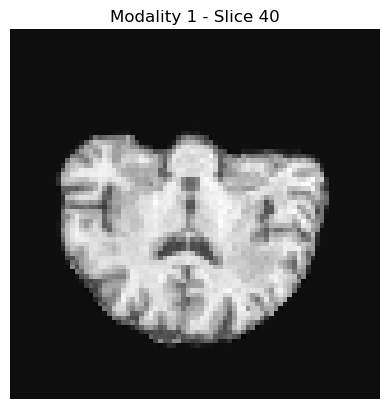

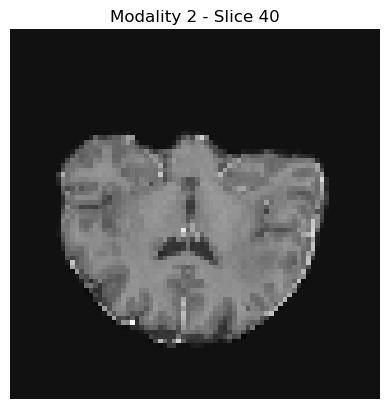

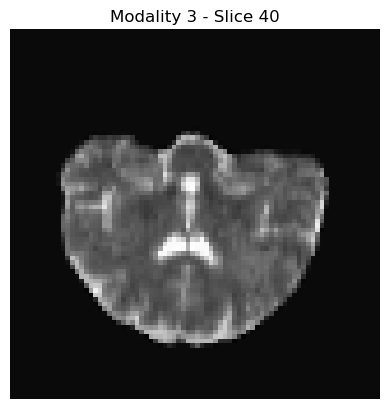

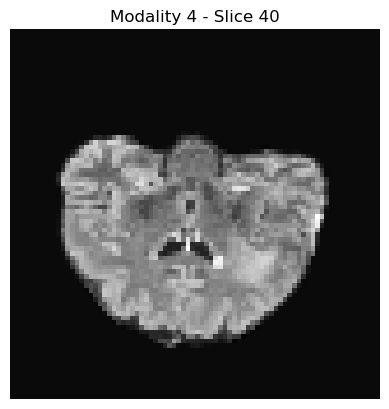

In [4]:
from Data.data_provider_brats import data_loader_3D 
from config.reader import read_config
import os
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Configuration file path
cfg_path = r'C:\Users\fahim\Documents\Research_project\F2NetViT\config\config.yaml'
# Configuration file path
# Read configuration
config = read_config(cfg_path)

# Create dataset
train_dataset = data_loader_3D(cfg_path, mode='train', modality=4, multimodal=True, site=None, image_downsample=config['Network']['image_downsample'])
val_dataset = data_loader_3D(cfg_path, mode='valid', modality=4, multimodal=True, site=None, image_downsample=config['Network']['image_downsample'])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=config['Network']['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['Network']['batch_size'], shuffle=False)

# Function to visualize a slice from the 3D image
def show_slice(img, title=None):
    plt.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Example of checking data loading and visualizing a slice
for images, labels in train_loader:
    print(images.shape, labels.shape)
    
    # Convert from torch tensor to numpy array
    img_np = images[0].numpy()  # Taking the first image in the batch
    label_np = labels[0].numpy()  # Taking the first label in the batch

    # Choose a slice from the 3D image (e.g., middle slice)
    slice_idx = img_np.shape[2] // 2

    # Display the slice
    for modality in range(img_np.shape[0]):
        show_slice(img_np[modality, :, :, slice_idx], title=f'Modality {modality+1} - Slice {slice_idx}')
    
    break  # Just visualize one batch for demonstration


CROPPING AND PADDING. 

If your images are not of the same size, you might need to crop or pad them to a consistent size.

In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

TRAINING THE MODEL

In [6]:
import math
import torch
from config.reader import read_config
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from Data.data_provider_brats import data_loader_3D
from unet3d import UNet3D
from transforms import train_transform_cuda, val_transform_cuda

# Configuration file path
cfg_path = r'C:\Users\fahim\Documents\Research_project\F2NetViT\config\config.yaml'
config = read_config(cfg_path)

# Create datasets and dataloaders
train_dataset = data_loader_3D(cfg_path, mode='train', modality=4, multimodal=True, image_downsample=config['Network']['image_downsample'], transform=train_transform_cuda)
val_dataset = data_loader_3D(cfg_path, mode='valid', modality=4, multimodal=True, image_downsample=config['Network']['image_downsample'], transform=val_transform_cuda)


def custom_collate(batch):
    images = torch.stack([item[0] for item in batch])
    labels = [item[1] for item in batch]
    if any(label is None for label in labels):
        labels = None
    else:
        labels = torch.stack(labels)
    return images, labels

train_loader = DataLoader(train_dataset, batch_size=config['Network']['batch_size'], shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=config['Network']['batch_size'], shuffle=False, collate_fn=custom_collate)

writer = SummaryWriter("runs")

model = UNet3D(in_channels=4, num_classes=4)  # Assuming 4 input channels (modalities) and 3 output classes (labels)

# Check if GPU is available and move model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() and config.get('TRAIN_CUDA', False) else "cpu")
model = model.to(device)
print(f"Using device: {device}")

criterion = CrossEntropyLoss(weight=torch.Tensor(config['class_weights']).to(device) if 'class_weights' in config else None)
optimizer = Adam(params=model.parameters())

min_valid_loss = math.inf

# Set iteration limit for debugging
iteration_limit = 5

for epoch in range(config['num_epochs']):
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        if i >= iteration_limit:
            break
        image, ground_truth = data
        image, ground_truth = image.to(device), ground_truth.to(device)

        optimizer.zero_grad()
        target = model(image.float())

        print(f"Image shape before model: {image.shape}")

        ground_truth = torch.argmax(ground_truth, dim=1)
        loss = criterion(target, ground_truth.long())
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            if i >= iteration_limit:
                break
            
            # Check what is being returned by the DataLoader
            image, ground_truth = data
            image = image.to(device)
            ground_truth = ground_truth.to(device) if ground_truth is not None else None

            target = model(image.float())

            print(f"Input shape in forward UNet3D(unet3d.py): {image.shape}")

            if ground_truth is not None:
                ground_truth = torch.argmax(ground_truth, dim=1)
                loss = criterion(target, ground_truth.long())
                valid_loss += loss.item()
            else:
                print("No ground truth available for validation data.")

    writer.add_scalar("Loss/Train", train_loss / len(train_loader), epoch)
    writer.add_scalar("Loss/Validation", valid_loss / len(val_loader) if valid_loss != 0 else 0, epoch)

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader) if valid_loss != 0 else "N/A"}')

    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased ({min_valid_loss:.6f} --> {valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        torch.save(model.state_dict(), f'checkpoints/epoch{epoch+1}_valLoss{min_valid_loss:.6f}.pth')

writer.flush()
writer.close()

c:\Users\fahim\miniconda3\envs\brats_seg\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Path to patient directory: C:/Users/fahim/Documents/Research_project/F2NetViT/Dataset/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03008-101
Path to label: C:/Users/fahim/Documents/Research_project/F2NetViT/Dataset/BraTS2024-BraTS-GLI-TrainingData/training_data1_v2/BraTS-GLI-03008-101\BraTS-GLI-03008-101-seg.nii.gz
(data_provider_brats.py) Before transform - Image shape: (4, 80, 80, 80), Label shape: (4, 80, 80, 80)
(data_provider_brats.py) After transform - Image shape: torch.Size([4, 80, 80, 80]), Label shape: torch.Size([4, 80, 80, 80])
Input shape in forward UNet3D(unet3d.py): torch.Size([1, 4, 80, 80, 80])
Input shape in forward in Conv3DBlock (unet3d.py): torch.Size([1, 4, 80, 80, 80])
Input shape in forward in Conv3DBlock (unet3d.py): torch.Size([1, 64, 40, 40, 40])
Input shape in forward in Conv3DBlock (unet3d.py): torch.Size([1, 128, 20, 20, 20])
Input shape in forward in Conv3DBlock (unet3d.py): torch.Size([1, 256, 10, 10, 10])
Upsampled ten

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.91 GiB. GPU 